---
## ODF Classifier with BioBERT  
---
### Content
---

- **[Libraries to use](#Libraries_to_use)**

- **[Loading the dataset](#Loading_dataset)**

- **[Cleaning the dataset and extracting required features](#Cleaning_extracting)**

- **[Including reversed findings to the dataset](#Reversed_findings)**

- **[Creating a dictionary with train, test, validation datasets](#train_test_validation)**

- **[Load tokenizer and model](#tokenizer_model)**

- **[Tokenize the datasets](#tokenize)**

- **[Formating to torch](#Formating)**

- **[Extracting hidden states](#Extracting_hidden_states)**

- **[Creating a feature matrix](#feature_matrix)**

- **[Visualizing the training set](#Visualizing_training)**

- **[Training a classifier](#Training_classifier)**

 ---

---
### Libraries to use <a id="Libraries_to_use"> </a>
---

In [35]:
#------------------------------------------------------
# Regular modules
#------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import ast
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
#------------------------------------------------
#------------------------------------------------------
# To avoid warnings
#------------------------------------------------------
import os
import warnings 
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#------------------------------------------------------
# Not regular modules
#------------------------------------------------------
import datasets
import torch
from umap import UMAP
from transformers import AutoTokenizer, AutoModel,AutoModelForSequenceClassification
#------------------------------------------------------
# Created modules
#------------------------------------------------------
from Classifier import data_cleaning  
from Classifier import including_reversing 
from Classifier import train_test_validation  

---
### Loading the dataset <a id="Loading_dataset"> </a>
---

In [2]:
real = pd.read_csv("../data/UpperGI.csv")
real  =real.rename(columns={"out":"text"})
real = data_cleaning(real)
real = real[['findings']]
real['label'] = 0
real=real.iloc[0:100]

In [3]:
real.head()

,findings,label
0,Columnar lined oesophagus is present. The segm...,0
1,There is an ulcer in the stomach which is supe...,0
2,LA Grade D oesophagitis. The oesopahgitis is ...,0
3,There is a polyp in the body which is sessile ...,0
4,There is a stricture in the fundus which is Oe...,0


In [4]:
def cleaning_generated_data(fake):
    fake=fake.rename(columns={"generated_findings":"findings"})
    def regex_findings(string):
        line=ast.literal_eval(string)
        output =line[0]['generated_text']
        hospital_reg = r"\.*FINDINGS:.*"
        output = re.findall(hospital_reg, output)[0][10:]
        return output
    fake["findings"] = fake['findings'].apply(regex_findings)
    fake['label'] = 1
    return fake

In [5]:
fake = pd.read_csv("../data/findings100_3_13.csv")
fake = fake[['findings']]
fake['label'] = 1

In [6]:
fake

,findings,label
0,Normal gastroscopy to the duodenum.,1
1,Normal gastroscopy to the duodenum.,1
2,Normal gastroscopy to the duodenum.,1
3,The patient has Barrett's oesophagus. No loss...,1
4,Normal gastroscopy to the duodenum.,1
...,...,...
95,The oesophagus appears to have a mildly friab...,1
96,There is a nodule in the antrum which is beni...,1
97,The patient has a 9mm nodule in the third par...,1
98,Large sliding hiatus hernia. inorad for Exam:...,1


---
### Including reversed findings to the dataset <a id="Reversed_findings"> </a>
---

In [7]:
fake_real = pd.concat([fake, real])

In [8]:
fake_real.reset_index(drop=True, inplace=True)
fake_real.head()

,findings,label
0,Normal gastroscopy to the duodenum.,1
1,Normal gastroscopy to the duodenum.,1
2,Normal gastroscopy to the duodenum.,1
3,The patient has Barrett's oesophagus. No loss...,1
4,Normal gastroscopy to the duodenum.,1


In [9]:
fake_real.tail(3)

,findings,label
197,Normal gastroscopy to the duodenum.,0
198,"list(""The stricture will need to be dilatated ...",0
199,There is a polyp in the antrum which is stalke...,0


---
### Creating a dictionary with train, test, validation datasets <a id="train_test_validation"> </a>
---

In [10]:
Dict_datasets = train_test_validation(fake_real)

In [11]:
Dict_datasets

DatasetDict({
    train: Dataset({
        features: ['findings', 'label'],
        num_rows: 98
    })
    test: Dataset({
        features: ['findings', 'label'],
        num_rows: 60
    })
    validation: Dataset({
        features: ['findings', 'label'],
        num_rows: 42
    })
})

---
### Load tokenizer and model <a id="tokenizer_model"> </a>
---

- BioBERT is a pre-trained language model that is designed for biomedical natural language processing (NLP) tasks. It is based on the Google's BERT (Bidirectional Encoder Representations from Transformers) architecture.

- BioBERT is pre-trained on a large corpus of biomedical text data, which includes abstracts and full-text articles from PubMed Central and other biomedical databases. 

---

In [12]:
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")

In [13]:
model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1", num_labels=2)

---
### Tokenize the datasets <a id="tokenize"> </a>
---

In [14]:
#--------------------------------------------------------------------
# define function to tokenize the datasets
#--------------------------------------------------------------------
def tokenize(data):
    return tokenizer(data["findings"], padding=True, truncation=True,max_length=100) 
#--------------------------------------------------------------------
# tokenize datasets
#--------------------------------------------------------------------
Dict_datasets_encoded = Dict_datasets.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/98 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

Map:   0%|          | 0/42 [00:00<?, ? examples/s]

---
### Formating to torch <a id="Formating"> </a>
---

In [15]:
Dict_datasets_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

---
### Extracting hidden states <a id="Extracting_hidden_states"> </a>
---

How will extract the hidden states associated with each finding.

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}
dataset_hidden = Dict_datasets_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/98 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

Map:   0%|          | 0/42 [00:00<?, ? examples/s]

---
### Creating a feature matrix <a id="feature_matrix"> </a>
---

We will use the hidden states as input features and the labels as targets.

In [17]:
X_train = np.array(dataset_hidden["train"]["hidden_state"])
X_valid = np.array(dataset_hidden["validation"]["hidden_state"])
X_test = np.array(dataset_hidden["test"]["hidden_state"])
y_train = np.array(dataset_hidden["train"]["label"])
y_valid = np.array(dataset_hidden["validation"]["label"])
y_test = np.array(dataset_hidden["test"]["label"])
X_train.shape, X_valid.shape, X_test.shape

((98, 768), (42, 768), (60, 768))

### Store and save the feature matrix list (optional)

The feature_matrix_list that can be used in a classifiar is stored a saved. 

In [18]:
#feature_matrix_list = [X_train,X_valid,X_test,y_train,y_valid,y_test]

In [19]:
#np.save('feature_matrix_list.npy', np.array(feature_matrix_list, dtype=object), allow_pickle=True)

### Load the feature list (optional)

In [20]:
#feature_matrix_list_loaded = np.load('feature_matrix_list.npy', allow_pickle=True)
#[X_train,X_valid,X_test,y_train,y_valid,y_test]=feature_matrix_list_loaded

---
### Visualizing the training set <a id="Visualizing_training"> </a>
---

In [21]:
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,8.373403,4.737093,0
1,9.926908,4.834438,0
2,5.317347,5.871393,0
3,24.774963,-1.245294,1
4,5.589103,4.705098,1


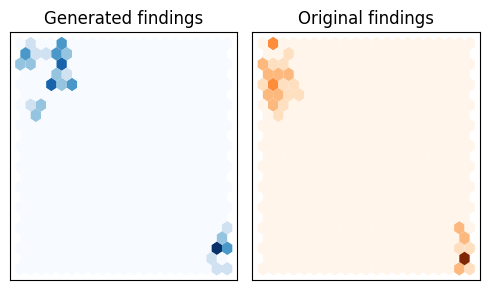

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(5,3))
axes = axes.flatten()
cmaps = ["Blues", "Oranges"]
labels = ['Generated findings','Original findings']

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

---
### Training a classifier <a id="Training_classifier"> </a>
---

In [23]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)

LogisticRegression()

### Evaluation of the discriminator

In [24]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
y_preds = dummy_clf.predict(X_test)
accuracy =accuracy_score(y_test, y_preds)
accuracy

NameError: name 'accuracy_score' is not defined

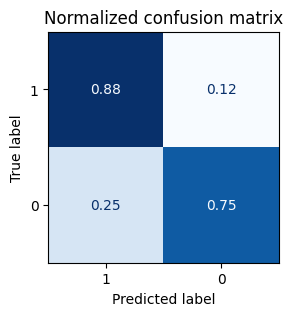

In [25]:
y_preds = lr_clf.predict(X_test)

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(3, 3))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(y_test,y_preds, [1,0])

In [36]:
accuracy =accuracy_score(y_test, y_preds)
precision = precision_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
f1 = f1_score(y_test, y_preds)
#------------------------------------------------
print('accuracy:',accuracy)
print('precision:',precision)
print('recall:',recall)
print('f1:',f1)

accuracy: 0.8
precision: 0.75
recall: 0.9
f1: 0.8181818181818182


### Classification of a single text

In [27]:
def single_text(lr_clf,custom_sentence,custom_label):
    """
    Input:
    """
    #-----------------------------------------------------
    inputs = tokenizer(custom_sentence, return_tensors="pt")
    #-----------------------------------------------------
    inputs = {k:v.to(device) for k,v in inputs.items()}
    with torch.no_grad():
            outputs = model(**inputs)
    #outputs.last_hidden_state.shape
    #-----------------------------------------------------
    preds_prob = lr_clf.predict_proba(np.array(outputs.last_hidden_state[:,0].cpu().numpy()))
    preds = lr_clf.predict(np.array(outputs.last_hidden_state[:,0].cpu().numpy()))
    #-----------------------------------------------------
    #preds_df = pd.DataFrame(preds[0])
    #-----------------------------------------------------
    plt.figure(figsize=(6,2))
    plt.bar(labels, 100 * preds_prob[0], color='red')
    plt.title(f'"{custom_sentence[:110]}..."')
    plt.ylabel("Class probability (%)")
    plt.show()


#### Example of false positive

#----------------------------------------------------------------------------------------
# Text
#----------------------------------------------------------------------------------------
There is a polyp in the body which is sessile with an abnormal pit pattern. A gastric polyp is seen in the pylorus, with a tubular and elongated shape and a smooth surface.The polyp was removed with minimal thermal injury to surrounding tissue using a cold snare technique..  FOLLOW UP: The patient should be advised to seek medical attention immediately if they experience severe abdominal pain, vomiting, or bloody stools. RECOMMENDATION: The patient should be advised to avoid NSAIDs and aspirin, which can increase the risk of developing more polyps.
#----------------------------------------------------------------------------------------
# Label
#----------------------------------------------------------------------------------------
Real medical report
#-------------------------------------------------

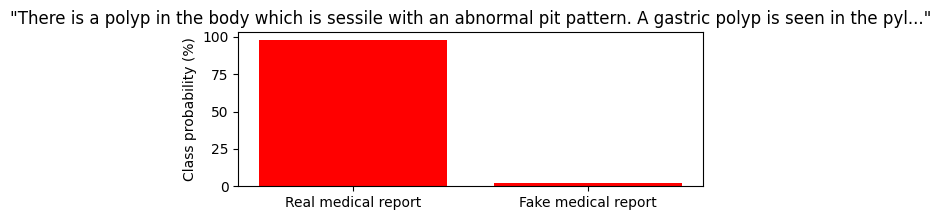

In [28]:
item=3
print('#----------------------------------------------------------------------------------------')
print('# Text')
print('#----------------------------------------------------------------------------------------')
custom_label = real['label'].iloc[item]
custom_sentence=real['findings'].iloc[item]
labels = ['Real medical report','Fake medical report']
print(custom_sentence)
print('#----------------------------------------------------------------------------------------')
print('# Label')
print('#----------------------------------------------------------------------------------------')
print(labels[custom_label])
print('#----------------------------------------------------------------------------------------')
single_text(lr_clf,custom_sentence,custom_label)

#### Example of false negative

#----------------------------------------------------------------------------------------
# Text
#----------------------------------------------------------------------------------------
 The patient has a polyp in the oesophagus at 32 cm which is sessile.It has an abnormal pit pattern. An oesophageal polyp was detected during endoscopy, located approximately 18 cm from the incisors. The lesion had a nodular surface and measured 1.2 cm in diameter.The base of the polyp was cauterized with an argon plasma coagulator to prevent bleeding.. itdo renz.duodenal stricture
#----------------------------------------------------------------------------------------
# Label
#----------------------------------------------------------------------------------------
Fake medical report
#----------------------------------------------------------------------------------------


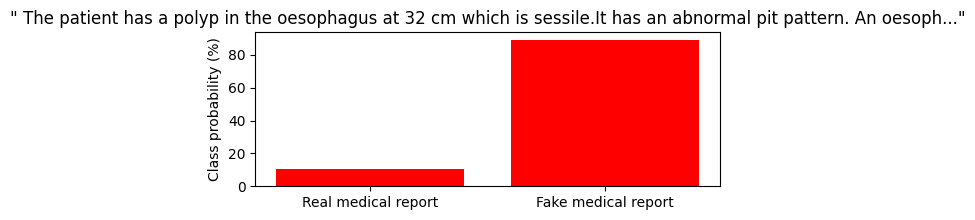

In [29]:
item=70
print('#----------------------------------------------------------------------------------------')
print('# Text')
print('#----------------------------------------------------------------------------------------')
custom_label = fake['label'].iloc[item]
custom_sentence=fake['findings'].iloc[item]
labels = ['Real medical report','Fake medical report']
print(custom_sentence)
print('#----------------------------------------------------------------------------------------')
print('# Label')
print('#----------------------------------------------------------------------------------------')
print(labels[custom_label])
print('#----------------------------------------------------------------------------------------')
single_text(lr_clf,custom_sentence,custom_label)

### Error analysis

In [30]:
from torch.nn.functional import cross_entropy
model = AutoModelForSequenceClassification.from_pretrained("dmis-lab/biobert-v1.1", num_labels=2)
def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        #pred_label = lr_clf.predict(np.array(output.last_hidden_state[:,0].cpu().numpy()))
        loss = cross_entropy(output.logits, batch["label"].to(device), 
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns   
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

def label_int2str(row):
    return Dict_datasets["train"].features["label"].int2str(row)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
#hide_output
# Convert our dataset back to PyTorch tensors
Dict_datasets_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
Dict_datasets_encoded["test"] = Dict_datasets_encoded["test"].map(
    forward_pass_with_label, batched=True)

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

In [37]:
Dict_datasets_encoded.set_format("pandas")
cols = ["findings", "label", "predicted_label", "loss"]
df_test = Dict_datasets_encoded["test"][:][cols]
df_test
df_test.sort_values("loss", ascending=True)#.head(10)

,findings,label,predicted_label,loss
17,The patient has a stricture in the D1 / D2 an...,1,1,0.598101
6,The oesophagus appears to have a mildly friab...,1,1,0.616404
50,Large sliding hiatus hernia. inorad for Exam:...,1,1,0.634913
22,The man has a polyp in the fundus which is st...,1,1,0.635709
43,There is a nodule in the GOJ which is sessile...,1,1,0.639354
1,There is an ulcer in the third part of the du...,1,1,0.640691
24,There is an ulcer in the oesophagus at 41 cm ...,1,1,0.642186
12,No cervical inlet patch.. abad abad abregular...,1,1,0.642517
21,Oesophagus - Small hiatus hernia.. ani also C...,1,1,0.643009
2,The patient has Barrett's oesophagus. Short s...,1,1,0.646957


### Similarity

High loss means that identify a class (1: real, 2: false) easily.

## Conclusions

- The classifier took the real and generated reports and was able to classify them with an accuracy of around 60% 

 